# Quantum Probability Image Encoding

In [2]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT
import matplotlib.pyplot as plt
from qiskit.visualization import array_to_latex
from scipy.fft import fft2, ifft2
from skimage import io
from skimage.transform import resize
import h5py
from skimage import color

Quantum Probability Image Enconding (QPIE) is an image encoding for quantum computers, where the color information encoded in the amplitudes. The state is given by $|I\rangle = \sum_{i=0}^{2^{2n-1}}c_i|i\rangle$, with $c_i = \frac{I'(i)}{||I'||}$ and $I' = (I_{1,1},I_{2,1},...,I_{n,n})^T$ are is flatten image pixel values. 

Using Qiskit, this state is easily prepared using the initialize() method. Following method, create circuit for encoding an image given in input. Image has to be size $2^n\times2^n$ (at least for now...).

In [11]:
def qpie_circuit(im): #for square image 2^n * 2^n

    n = int(np.log2(len(im)))

    vals = im.flatten()
    vals = vals/np.linalg.norm(vals) #normalize coefficients
    qc = QuantumCircuit(2*n)

    qc.initialize(vals)

    return qc

Let's now define an image, for example a small 2x2 square in a 32x32 image, and show its circuit.

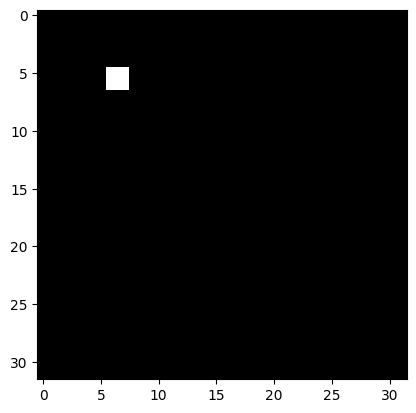

In [ ]:
im = np.zeros((32,32))
im[5,6] = 1
im[6,6] = 1
im[5,7] = 1
im[6,7] = 1
plt.imshow(im,cmap='gray')

And let's endode it in a circuit, and print the circuit.

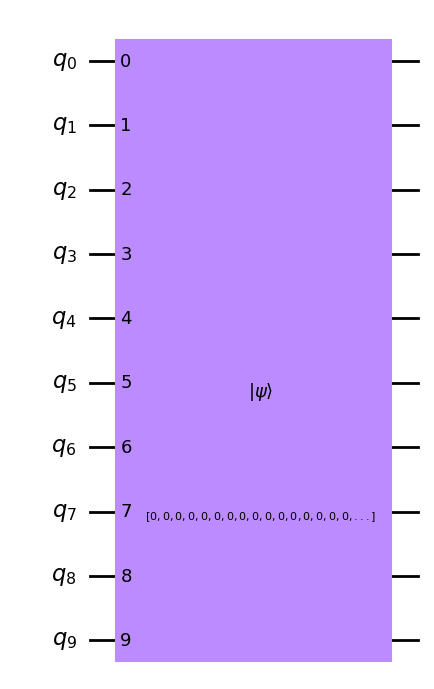

In [ ]:
qc = qpie_circuit(im)
qc.draw('mpl')

Now, we try to decode out from the circuit above. To do so, a function decode_out is defined. It will take as input the circuit corresponding to the encoded image, do the measurements and reconstruct the image from the obtained probabilities.

In [4]:
def decode_out(qc,norm,fourier=False,shots_mult=1):
    
    n = qc.num_qubits
    shots = shots_mult * 2**20 #number of shots desired

    backend = Aer.get_backend('qasm_simulator')
    results = execute(qc, backend=backend, shots=shots).result()
    answer = results.get_counts()

    outim = np.zeros((int(2**(n/2)), int(2**(n/2))))

    b = 0
    for i,j in np.ndindex(outim.shape):

        bit = format(b, '0' + str(n) + 'b')
        p_i = answer.get(bit,0)/shots
        
        if fourier:
            pix_val = np.sqrt(p_i) * norm * 2**(n/2)
        else:
            pix_val = np.sqrt(p_i) * norm
            
        outim[i,j] = (pix_val)
        b+=1
    
    return outim

Now, let's try with our image defined above.

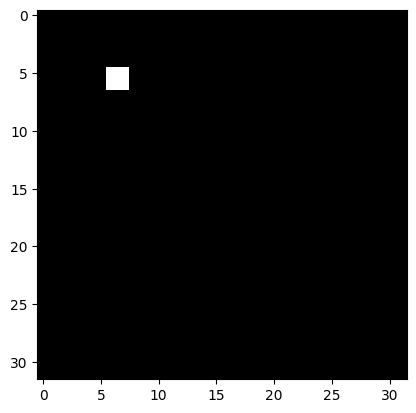

In [ ]:
qc.measure_all() #we don't forget to add measurement

norm = (np.linalg.norm(im.flatten()))
imout = decode_out(qc,norm)
plt.imshow(imout,cmap='gray')

We see that the image looks the same. Let's now try to see the absolute difference between the 2.

In [5]:
def MSE(im1,im2):

    im = (im1-im2)**2
    s = np.sum(im.flatten())/(len(im1**2))

    return s

In [ ]:
MSE(im,imout)

2.1981161116172456e-07

Let's now try to Fourier Transform the image, using the quantum fourier transform. To do that, we simply add QFT circuit from qiskit in our previous circuit, and decode out. One (small) problem is that the QFT add a factor 1/sqrt(N), so when decoding, we need not to forget to multiply it if we want to compare with real result.

[[4.0350031  3.93501906 3.9310463  ... 3.80583434 3.91461604 3.93551537]
 [3.93849194 3.96764256 3.92706952 ... 3.81915403 3.94592353 3.95284708]
 [3.94097069 3.87348761 3.835484   ... 3.68961804 3.83599319 3.89059362]
 ...
 [3.78886114 3.82324306 3.78060428 ... 3.68166912 3.78267019 3.81454863]
 [3.96715027 3.92657214 3.7904073  ... 3.74739493 3.84717835 3.88003705]
 [4.00780489 3.92607469 3.89059362 ... 3.84768599 3.88607289 3.93601162]]


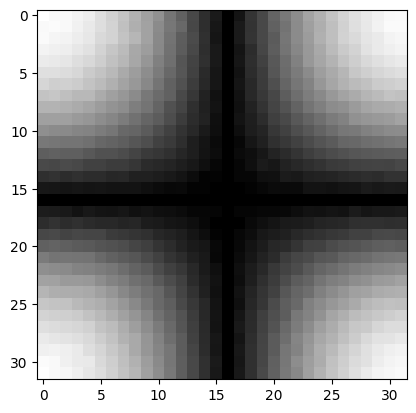

In [ ]:
qc = qpie_circuit(im)

qc.append(QFT(5,insert_barriers=True, name='QFT'),[0,1,2,3,4])
qc.append(QFT(5,insert_barriers=True, name='QFT'),[5,6,7,8,9])

qc.measure_all()

qc.draw('mpl')

imout = decode_out(qc,norm,True)
print(imout)
plt.imshow(imout,cmap='gray')

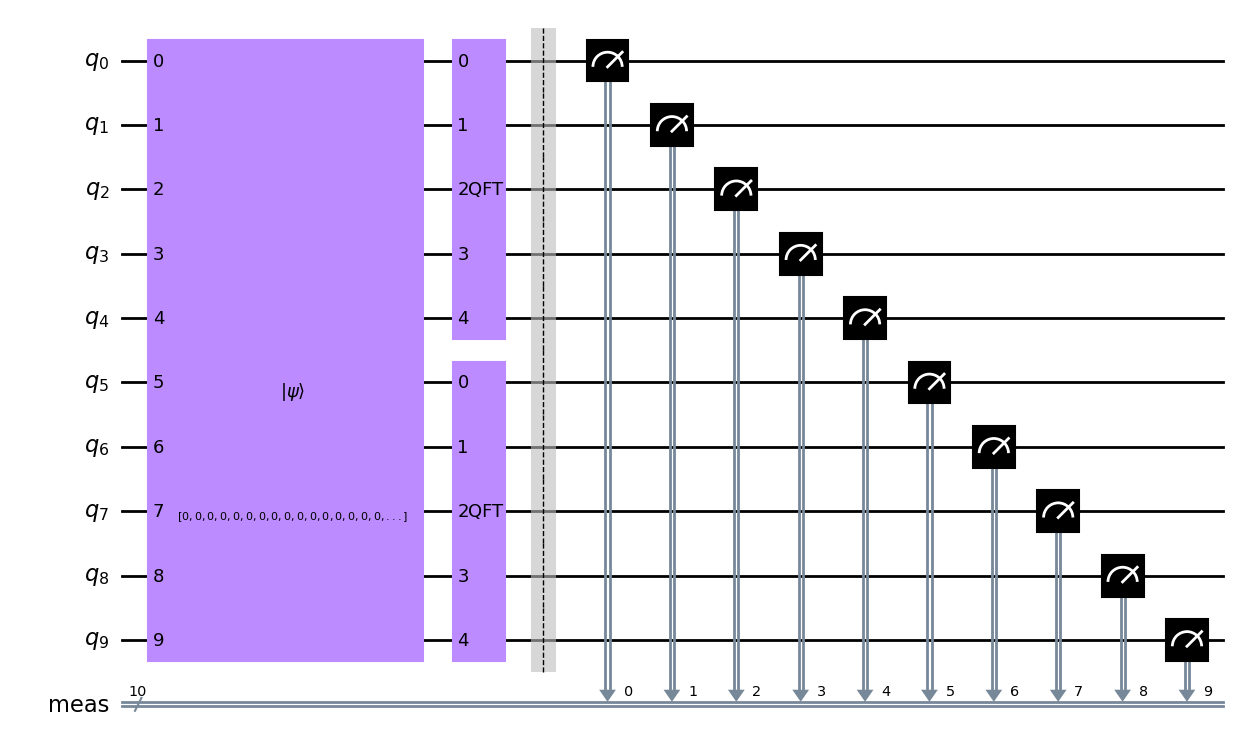

In [ ]:
qc.draw('mpl')

Let's compare with the 'true' result, using scipy FFT.

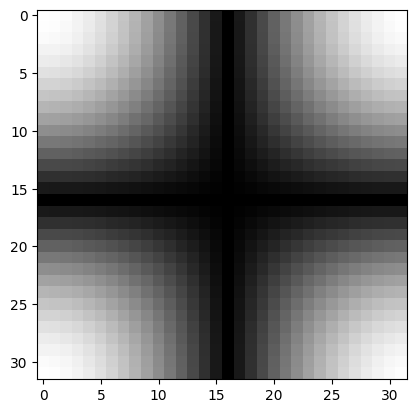

In [ ]:
ft = fft2(im)
plt.imshow(np.abs(ft),cmap='gray')

Our QFT looks pretty good, let's now compare the bit value, using MSE again.

In [ ]:
MSE(imout,np.abs(ft))

0.029057328506956498

Let's now try the same for different images :

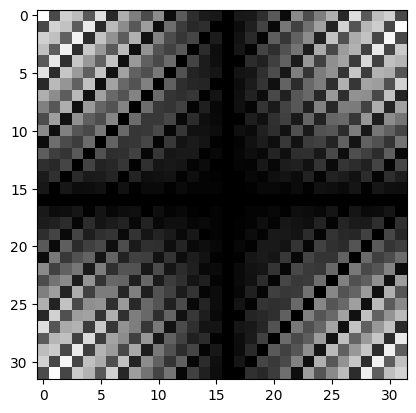

In [ ]:
#2 2x2 squares in a 32x32 image
im = np.zeros((32,32))
im[5,6] = 1
im[6,6] = 1
im[5,7] = 1
im[6,7] = 1
im[24,25] = 1
im[25,25] = 1
im[24,26] = 1
im[25,26] = 1
norm = (np.linalg.norm(im.flatten()))

qc = qpie_circuit(im)

qc.append(QFT(5,insert_barriers=True, name='QFT'),[0,1,2,3,4])
qc.append(QFT(5,insert_barriers=True, name='QFT'),[5,6,7,8,9])

qc.measure_all()

imout = decode_out(qc,norm,True)
plt.imshow(imout,cmap='gray')

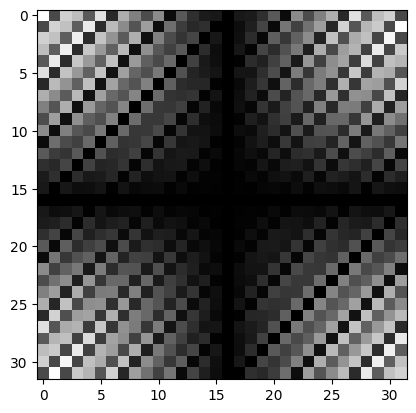

In [ ]:
ft = fft2(im)
plt.imshow(np.abs(ft),cmap='gray')

In [ ]:
MSE(imout,np.abs(ft))

0.05887532581853118

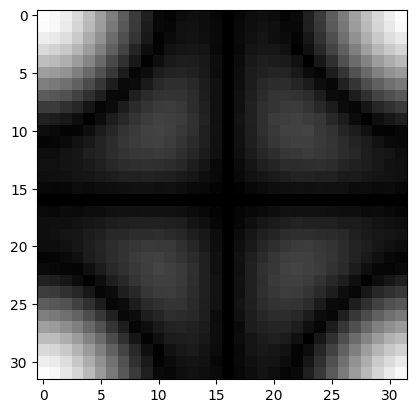

In [ ]:
#a small circle in 32x32 image
im = np.zeros((32,32))
im[4,4]=1
im[4,5]=1
im[5,4]=1
im[5,5]=1
im[6,4]=1
im[6,5]=1
im[7,4]=1
im[7,5]=1
im[5,3]=1
im[6,3]=1
im[5,5]=1
im[6,6]=1
im[5,6]=1
norm = (np.linalg.norm(im.flatten()))

qc = qpie_circuit(im)

qc.append(QFT(5,insert_barriers=True, name='QFT'),[0,1,2,3,4])
qc.append(QFT(5,insert_barriers=True, name='QFT'),[5,6,7,8,9])

qc.measure_all()

imout = decode_out(qc,norm,True)
plt.imshow(imout,cmap='gray')

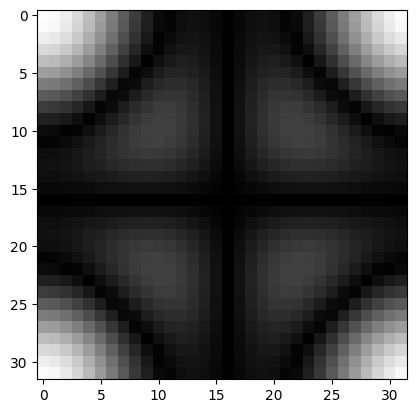

In [ ]:
ft = fft2(im)
plt.imshow(np.abs(ft),cmap='gray')

In [ ]:
MSE(imout,np.abs(ft))

0.09352350485432864

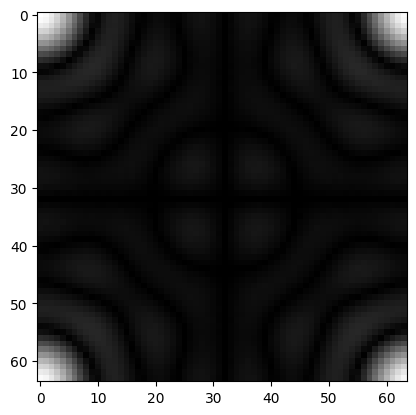

In [ ]:
#a bigger circle in a 64x64 image
im = np.zeros((64,64))
im[10:14,10:18] =1
im[9,11:17]=1
im[8,12:16]=1
im[14,11:17]=1
im[15,12:16]=1
norm = (np.linalg.norm(im.flatten()))

qc = qpie_circuit(im)

qc.append(QFT(6,insert_barriers=True, name='QFT'),[0,1,2,3,4,5])
qc.append(QFT(6,insert_barriers=True, name='QFT'),[6,7,8,9,10,11])

qc.measure_all()

imout = decode_out(qc,norm,True,10)
plt.imshow(imout,cmap='gray')

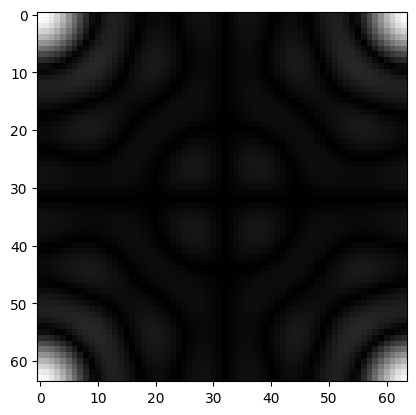

In [ ]:
ft = fft2(im)
plt.imshow(np.abs(ft),cmap='gray')

In [ ]:
MSE(imout,np.abs(ft))

0.3209898035225213

Let's try now on real 256x256 images.

In [ ]:
img = io.imread('lena.jpg', as_gray=True)
im = resize(img,(256,256))
norm = (np.linalg.norm(im.flatten()))

qc = qpie_circuit(im)
qc.measure_all() #First let's just encode/decode out, then we will see the Fourier Transform

imout = decode_out(qc,norm)

plt.figure()
plt.imshow(imout,cmap='gray')
MSE(imout,im)

NameError: name 'io' is not defined

Here, we observe the MSE is a bit big, and the image is noisy. This is due to the fact that we do probabilistic measurements : to get a less noisy image, we need to do more shots, let's try it.

0.0803728496554139

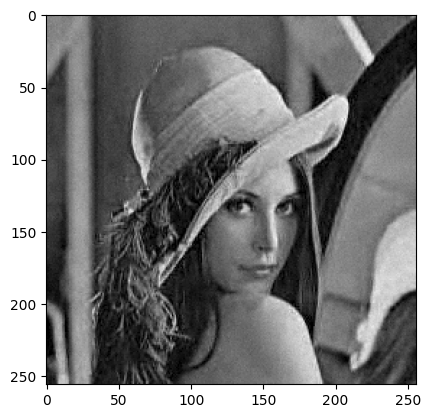

In [ ]:
qc = qpie_circuit(im)
qc.measure_all() #First let's just encode/decode out, then we will see the Fourier Transform

imout = decode_out(qc,norm,False,10)
plt.figure()
plt.imshow(imout,cmap='gray')

MSE(imout,im)

And we seem by multplying by 10 the number of shots, the result is much better. Let's now try to Fourier transform it.

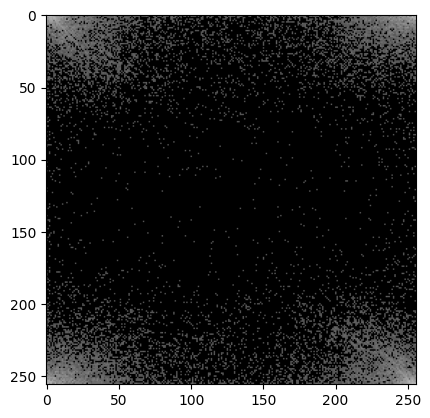

In [ ]:
qc = qpie_circuit(im)
qc.append(QFT(8, insert_barriers=True, name='QFT'),[0,1,2,3,4,5,6,7])
qc.append(QFT(8, insert_barriers=True, name='QFT'),[8,9,10,11,12,13,14,15])
qc.measure_all()

imout = decode_out(qc,norm,True)
plt.figure()
plt.imshow(np.log(imout+1),cmap='gray') #here we take log + 1 bc pixel value are very small.

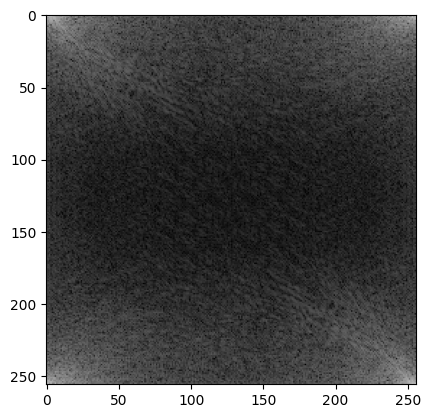

In [ ]:
ft = fft2(im)
plt.figure()
plt.imshow(np.log(np.abs(ft)+1),cmap='gray')

In [ ]:
MSE(np.log(imout+1),np.log(np.abs(ft)+1))

812.0880402813959

Here, same observation as a simple encode/decode, but the difference is even bigger. This is really due to a lack of shots, because the pixels at the center have a very small value and so also a small probability to be obtained. Adding even more shots will improve the image obtained.

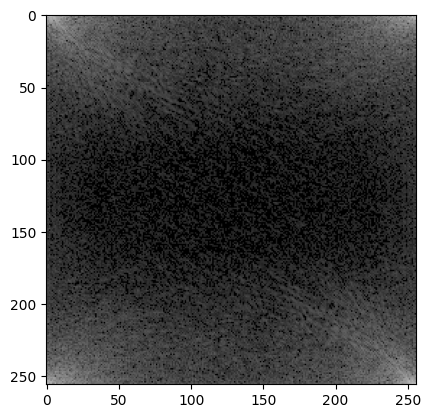

In [ ]:
qc = qpie_circuit(im)
qc.append(QFT(8, insert_barriers=True, name='QFT'),[0,1,2,3,4,5,6,7])
qc.append(QFT(8, insert_barriers=True, name='QFT'),[8,9,10,11,12,13,14,15])
qc.measure_all()

imout = decode_out(qc,norm,True,100)
plt.figure()
plt.imshow(np.log(imout+1),cmap='gray') #here we take log + 1 bc pixel value are very small.

In [ ]:
MSE(np.log(imout+1),np.log(np.abs(ft)+1))

66.21973502714742

MSE has drastically went down, and we even see the image is less noisy, as said.

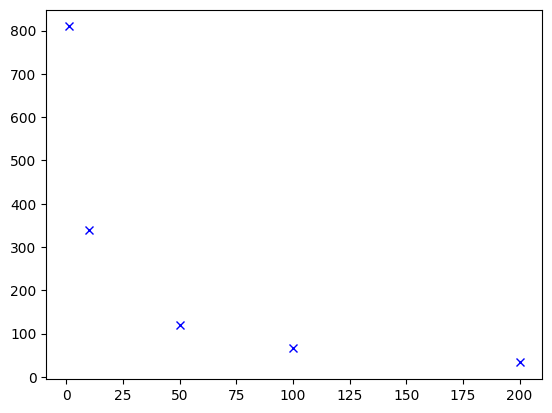

In [ ]:
shots = [1,10,50,100,200]
MSEs = []
for s in shots:
    
    qc = qpie_circuit(im)
    qc.append(QFT(8, insert_barriers=True, name='QFT'),[0,1,2,3,4,5,6,7])
    qc.append(QFT(8, insert_barriers=True, name='QFT'),[8,9,10,11,12,13,14,15])
    qc.measure_all()

    imout = decode_out(qc,norm,True,s)
    MSEs.append(MSE(np.log(imout+1),np.log(np.abs(ft)+1)))

plt.plot(shots,MSEs,'bx')
plt.show()

In [ ]:
MSE(np.log(imout+1),np.log(np.abs(ft)+1)) #for 200 shots

33.38769740627381

Major problem now is that it takes a lot of time to obtain some good images. Approx 5min for the 100 shots one, using my computer.

We can now see with real astronomy images. What else ?

In [ ]:
with h5py.File('Galaxy10_DECals.h5', 'r') as F:
    images = np.array(F['images'][0:10])#take 10 galaxy images in the dataset

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'Galaxy10_DECals.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

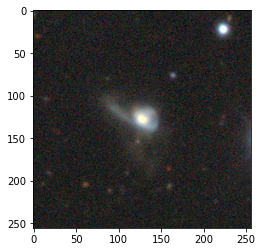

In [ ]:
plt.imshow(images[2])

In [ ]:
img = []#convert to grayscale
norms = []
for i in range(10):
    img.append(color.rgb2gray(images[i]))
    norms.append((np.linalg.norm(img[i].flatten())))
    

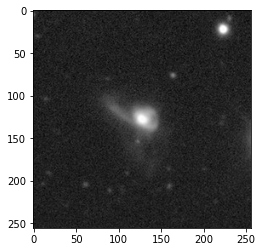

In [ ]:
plt.imshow(img[2],cmap='gray')

0.12165215449847566

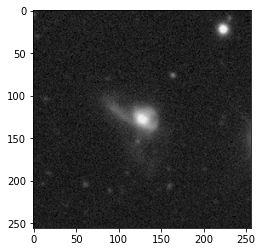

In [ ]:
#encode/decode first
im = img[2]
norm = norms[2]
qc = qpie_circuit(im)
qc.measure_all() #First let's just encode/decode out, then we will see the Fourier Transform

imout = decode_out(qc,norm)
plt.figure()
plt.imshow(imout,cmap='gray')

MSE(imout,im) #works well, MSE is small

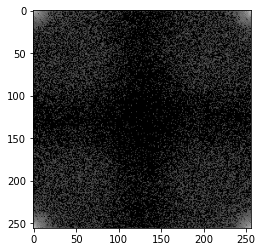

In [ ]:
qc = qpie_circuit(im)
qc.append(QFT(8, insert_barriers=True, name='QFT'),[0,1,2,3,4,5,6,7])
qc.append(QFT(8, insert_barriers=True, name='QFT'),[8,9,10,11,12,13,14,15])
qc.measure_all()

imout = decode_out(qc,norm,True)
plt.figure()
plt.imshow(np.log(imout+1),cmap='gray') #here we take log + 1 bc pixel value are very small.

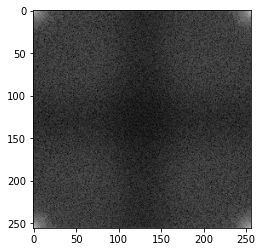

In [ ]:
ft = fft2(im)
plt.figure()
plt.imshow(np.log(np.abs(ft)+1),cmap='gray')

In [ ]:
MSE(np.log(imout+1),np.log(np.abs(ft)+1))

520.310676918798

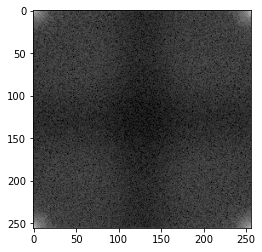

In [ ]:
#with more shots
qc = qpie_circuit(im)
qc.append(QFT(8, insert_barriers=True, name='QFT'),[0,1,2,3,4,5,6,7])
qc.append(QFT(8, insert_barriers=True, name='QFT'),[8,9,10,11,12,13,14,15])
qc.measure_all()

imout = decode_out(qc,norm,True,100)
plt.figure()
plt.imshow(np.log(imout+1),cmap='gray') #here we take log + 1 bc pixel value are very small.

In [ ]:
MSE(np.log(imout+1),np.log(np.abs(ft)+1)) #much better ofc, but long time.

6.166223504994666

In [9]:
from scipy.optimize import minimize
def swap_test(state1, state2): #Function to perform swap test between 2 given states
    
    anc = QuantumRegister(1,name='ancilla') #ancilla qubit 
    meas = ClassicalRegister(1) #measurement
    state_1 = QuantumRegister(state1.num_qubits,name='state1') #register for state 1
    state_2 = QuantumRegister(state2.num_qubits,name='state2') #and state 2

    qc = QuantumCircuit(anc,state_1,state_2,meas) #define the quantum circuit

    #Then we just apply SWAP test : H on ancilla, load the states, SWAPS and H on ancilla
    qc.h(anc) 
    qc.append(state1,state_1)
    qc.append(state2,state_2)

    for i in range(1,state1.num_qubits+1):
        qc.cswap(0,i,i+state1.num_qubits)
    
    qc.h(anc)
    qc.measure(anc,meas) #meaasure ancilla

    return qc

class swap_calib():

    def __init__(self, V_ij, V_ijtilda, learn_param = 0.01, nloops = 1000, shift = np.pi/2):

        self.V_ij = V_ij
        self.V_ijtilda = V_ijtilda
        self.learn = learn_param
        self.nloops = nloops
        self.shift = shift
        self.cost = []
        self.steps = []
        self.V_ijtilda_qc = qpie_circuit(V_ijtilda)
    
    def cost_function(self,params): #cost function : return proba of ancilla being in |1>.

        G_ = np.outer(params,params.T)
        V_ij_ = G_ * self.V_ij #compute with actual parameters

        state1 = qpie_circuit(V_ij_)
        qc = swap_test(state1,self.V_ijtilda_qc) 

        backend = Aer.get_backend('qasm_simulator')
        results = execute(qc, backend=backend, shots=1024).result()
        answer = results.get_counts() #do simulation

        return answer.get('1',0)/1024 #return proba
    
    def gradient_function(self,params): #return the gradients, computed with shift rule

        gradient = np.zeros(params.shape[0])
        shift = self.shift

        for i in range(params.shape[0]):
            shift_p = params.copy()
            shift_p[i] += shift

            shift_m = params.copy()
            shift_m[i] -= shift

            cost_p = self.cost_function(shift_p)
            cost_m = self.cost_function(shift_m)

            gradient[i] = 1/2 * (cost_p - cost_m)

        return gradient
    
    def grad_desc(self,params): #loop for gradient descent

        for i in range(self.nloops):
            params = params - self.learn * self.gradient_function(params)
            self.cost.append(self.cost_function(params))
            self.steps.append(i)

        return params/np.linalg.norm(params)
    
    def class_opti(self, params): #classical optimizer

        res = minimize(self.cost_function, params, method='COBYLA', tol=1e-9)
        
        return res.x/np.linalg.norm(res.x), res.nfev

experiment number {i} is done
experiment number {i} is done
experiment number {i} is done
experiment number {i} is done
experiment number {i} is done
experiment number {i} is done
experiment number {i} is done
experiment number {i} is done
experiment number {i} is done
experiment number {i} is done
experiment number {i} is done
experiment number {i} is done
experiment number {i} is done
experiment number {i} is done
experiment number {i} is done
experiment number {i} is done
experiment number {i} is done
experiment number {i} is done
experiment number {i} is done
experiment number {i} is done
experiment number {i} is done
experiment number {i} is done
experiment number {i} is done
experiment number {i} is done
experiment number {i} is done
experiment number {i} is done
experiment number {i} is done
experiment number {i} is done
experiment number {i} is done
experiment number {i} is done
experiment number {i} is done
experiment number {i} is done
experiment number {i} is done
experiment

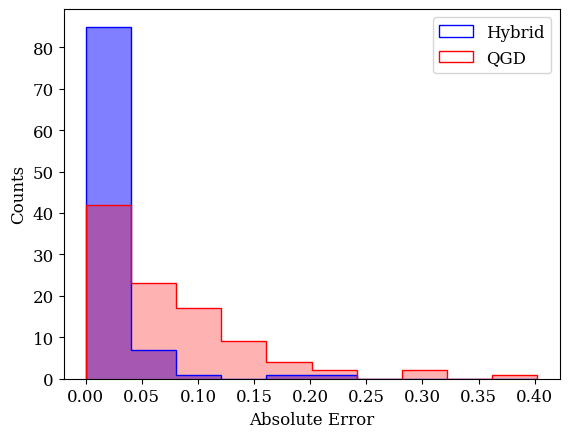

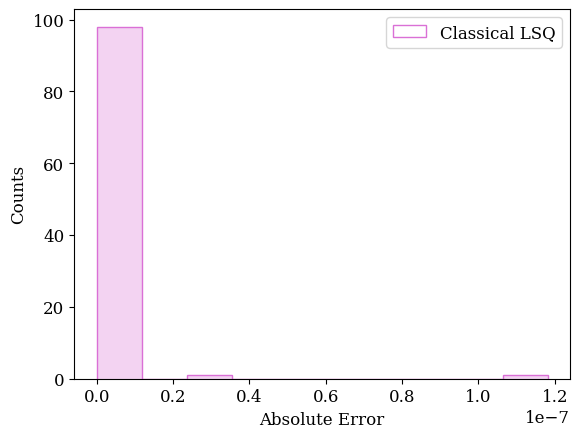

In [12]:
from qiskit.circuit.library import QFT
from scipy.optimize import least_squares as lsq
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Times']
rcParams['font.size'] = 12

##To use calibration, first empty lists for observations

inits = []
opti_class = []
opti_gd = []
good_g = []

diff_class = []
diff_gd = []
diff_full = []

cost_init = []
cost_gd = []
cost_clas = []
cost_g = []
cost_fullclass = []

it_clas=[]

his_fullclas  = []
his_clas = []
his_q = []

for i in range(50): #number of experience you want

    V_ij = np.random.rand(2,2) #True observation
    g = np.random.rand(2) #True g we want to find
    g = g/np.linalg.norm(g)
    G = np.outer(g,g.T)
    V_ijtilda = G * V_ij #Observed visibilities

    def loss(x): #loss for least squares fct from scipy
        G = np.outer(x,x.T)
        V_reco = G*V_ij
        return (V_reco - V_ijtilda).flatten()

    parameters = np.random.rand(2) #random initial gains

    inits.append(parameters)
    good_g.append(g)

    var = swap_calib(V_ij,V_ijtilda) 

    cost_init.append(var.cost_function(parameters)) #compute cost for init params
    cost_g.append(var.cost_function(g)) #and for good g

    clas,nit = var.class_opti(parameters) #optimize with classical
    gd = var.grad_desc(parameters) #and with QGD
    clas_full = lsq(loss, parameters) #and classical with scipy lsq

    # We add to observations the results

    opti_class.append(clas)
    opti_gd.append(gd)
    it_clas.append(nit)

    cost_clas.append(var.cost_function(clas))
    cost_gd.append(var.cost_function(gd))


    diff_class.append(np.abs(clas-g))
    diff_gd.append(np.abs(gd-g))
    diff_full.append(np.abs(clas_full.x - g))

    his_clas.append(np.abs(clas[0]-g[0]))
    his_clas.append(np.abs(clas[1]-g[1]))
    his_q.append(np.abs(gd[0]-g[0]))
    his_q.append(np.abs(gd[1]-g[1]))
    his_fullclas.append(np.abs(clas_full.x[0]-g[0]))
    his_fullclas.append(np.abs(clas_full.x[1]-g[1]))
    print(f"experiment number {i} is done")
    # Uncomment if want QGD minimization over steps

    # plt.figure() #plot cost/step for QGD
    # plt.xlabel('Step',fontsize=15)
    # plt.ylabel('Cost Function', fontsize=15)
    # plt.plot(var.steps,var.cost)


#Prints observations
# print(inits)
# print(opti_class)
# print(opti_gd)
# print(good_g)
# print(diff_class)
# print(diff_gd)
# print(it_clas)
# print(cost_init)
# print(cost_clas)
# print(cost_gd)
# print(cost_g)

# print(his_clas)
# print(his_q)

counts, bins = np.histogram(his_q) #histogram with qgd and hybrid
plt.figure()

plt.xlabel('Absolute Error')
plt.ylabel('Counts')

plt.hist(his_clas, bins = bins, color = 'blue', alpha = 0.5, histtype = 'stepfilled')
plt.hist(his_clas, bins = bins, edgecolor = 'blue', alpha = 1.0, histtype = 'step', label='Hybrid')

plt.hist(his_q, bins = bins, color = 'red', alpha = 0.3, histtype = 'stepfilled')
plt.hist(his_q, bins = bins, edgecolor = 'red', alpha = 1.0, histtype = 'step', label = 'QGD')

plt.legend()

plt.figure() #histogram for full classical

counts, bins = np.histogram(his_fullclas)

plt.xlabel('Absolute Error')
plt.ylabel('Counts')

plt.hist(his_fullclas, bins = bins, color = 'orchid', alpha = 0.3, histtype = 'stepfilled')
plt.hist(his_fullclas, bins = bins, edgecolor = 'orchid', alpha = 1.0, histtype = 'step', label = 'Classical LSQ')

plt.legend()

plt.show() #57 minutes